Let's begin by loading and examining two datasets: one that contains a set of user demographics and the other -- a set of data relating to in-app purchases for our meditation app.

In [11]:
# Import pandas 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the customer_data
customer_data = pd.read_csv('customer_demographics.csv')

# Load the app_purchases
app_purchases = pd.read_csv('purchase_data.csv')

# Print the columns of customer data
print(customer_data.columns)

# Print the columns of app_purchases
print(app_purchases.columns)

Index(['uid', 'reg_date', 'device', 'gender', 'country', 'age'], dtype='object')
Index(['date', 'uid', 'sku', 'price'], dtype='object')


Merging on different sets of fields
As you saw in the previous exercise, both customer_data and app_purchases have a common 'uid' column that you can use to combine them. If you explored them further, you would discover that they also have a common date column that is named 'date' in app_purchases and 'reg_date' in customer_data.

In this exercise you will explore merging on both of these columns and looking at how this impacts your final results.

The two datasets from the previous exercise - customer_data and app_purchases- have been loaded for you, with 'reg_date' in customer_data renamed to 'date'.

In [12]:
# Merge on the 'uid' and 'date' field
purchase_data = app_purchases.merge(customer_data, on=['uid'], how='inner')

# Examine the results 
print(purchase_data.head())
print(len(purchase_data))

         date       uid            sku  price    reg_date device gender  \
0  2017-07-10  41195147  sku_three_499    499  2017-06-26    and      M   
1  2017-07-15  41195147  sku_three_499    499  2017-06-26    and      M   
2  2017-11-12  41195147   sku_four_599    599  2017-06-26    and      M   
3  2017-09-26  91591874    sku_two_299    299  2017-01-05    and      M   
4  2017-12-01  91591874   sku_four_599    599  2017-01-05    and      M   

  country  age  
0     BRA   17  
1     BRA   17  
2     BRA   17  
3     TUR   17  
4     TUR   17  
9006


Joining with both UID and date would return fewer rows compared to the first one - 35 compared to 9006! This is because there were fewer matches

## Practicing aggregations
It's time to begin exploring the in-app purchase data in more detail. Here, you will practice aggregating the dataset in various ways using the .agg() method and then examine the results to get an understanding of the overall data, as well as a feel for how to aggregate data using pandas.

In [13]:
# Calculate the mean and median of price and age
purchase_summary = purchase_data.agg({'price': ['mean', 'median'], 'age': ['mean', 'median']})

# Examine the output 
print(purchase_summary)

             price        age
mean    406.772596  23.922274
median  299.000000  21.000000


In [14]:
# Group the data 
grouped_purchase_data = purchase_data.groupby(by = ['device', 'gender'])

# Aggregate the data
purchase_summary = grouped_purchase_data.agg({'price': ['mean', 'median', 'std']})

# Examine the results
print(purchase_summary)

                    price                   
                     mean median         std
device gender                               
and    F       400.747504    299  179.984378
       M       416.237308    499  195.001520
iOS    F       404.435330    299  181.524952
       M       405.272401    299  196.843197


## Calculating KPIs
You're now going to take what you've learned and work through calculating a KPI yourself. Specifically, you'll calculate the average amount paid per purchase within a user's first 28 days using the purchase_data DataFrame from before.

This KPI can provide a sense of the popularity of different in-app purchase price points to users within their first month.

In [15]:
from datetime import datetime, timedelta

current_date = pd.to_datetime('2018-03-17')

In [16]:
# Compute max_purchase_date
max_purchase_date = current_date - timedelta(days=28)
max_purchase_date

Timestamp('2018-02-17 00:00:00')

In [17]:
purchase_data['date'] = pd.to_datetime(purchase_data['date'])
purchase_data['reg_date'] = pd.to_datetime(purchase_data['reg_date'])

purchase_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9006 entries, 0 to 9005
Data columns (total 9 columns):
date        9006 non-null datetime64[ns]
uid         9006 non-null int64
sku         9006 non-null object
price       9006 non-null int64
reg_date    9006 non-null datetime64[ns]
device      9006 non-null object
gender      9006 non-null object
country     9006 non-null object
age         9006 non-null int64
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 1023.6+ KB


In [18]:
# Filter to only include users who registered before our max date
purchase_data_filt = purchase_data[purchase_data['reg_date'] < max_purchase_date]

In [19]:
# Compute max_purchase_date
max_purchase_date = (current_date - timedelta(days=28))

# Filter to only include users who registered before our max date
purchase_data_filt = purchase_data[purchase_data['reg_date'] < max_purchase_date]

# Filter to contain only purchases within the first 28 days of registration
purchase_data_filt = purchase_data_filt[(purchase_data_filt['date'] <= 
                        purchase_data_filt['reg_date'] + timedelta(days=28))]

# Output the mean price paid per purchase
print(purchase_data_filt['price'].mean())

414.4237288135593


Interesting! Since our average price is 414 cents which is below $4.99 it seems that our purchasers tend towards the lower priced set of options.



## Average purchase price by cohort
Building on the previous exercise, let's look at the same KPI, average purchase price, and a similar one, median purchase price, within the first 28 days. Additionally, let's look at these metrics not limited to 28 days to compare.

We can calculate these metrics across a set of cohorts and see what differences emerge. This is a useful task as it can help us understand how behaviors vary across cohorts.

Note that in our data the price variable is given in cents.

In [20]:
# Set the max registration date to be one month before today
max_reg_date = current_date - timedelta(days=28)

# Find the month 1 values
month1 = np.where(

    # the user registration .reg_date occurred at most 28 days ago (i.e. before max_reg_date
    (purchase_data['reg_date'] < max_reg_date) &
    # the date of purchase .date occurred within 28 days of registration date .reg_date             
    (purchase_data.date < purchase_data['reg_date'] + timedelta(days=28)),
                  
                  purchase_data['price'], 
                  np.NaN)
                 
# Update the value in the DataFrame
purchase_data['month1'] = month1

# Group the data by gender and device 
purchase_data_upd = purchase_data.groupby(by=['gender', 'device'], as_index=False)

# Aggregate the month1 and price data 
purchase_summary = purchase_data_upd.agg(
                                        {'month1': ['mean', 'median'],
                                        'price': ['mean', 'median']})

# Examine the results 
print(purchase_summary)

  gender device      month1              price       
                       mean median        mean median
0      F    and  388.204545  299.0  400.747504    299
1      F    iOS  432.587786  499.0  404.435330    299
2      M    and  413.705882  399.0  416.237308    499
3      M    iOS  433.313725  499.0  405.272401    299


This value seems relatively stable over the past 28 days.

## Seasonality and moving averages
Stepping back, we will now look at the overall revenue data for our meditation app. We saw strong purchase growth in one of our products, and now we want to see if that is leading to a corresponding rise in revenue. As you may expect, revenue is very seasonal, so we want to correct for that and unlock macro trends.

In this exercise, we will correct for weekly, monthly, and yearly seasonality and plot these over our raw data. This can reveal trends in a very powerful way.

In [21]:
user_revenue = pd.read_csv('daily_revenue.csv')
daily_revenue = user_revenue.loc[:,['date', 'revenue']]

<Figure size 1440x720 with 0 Axes>

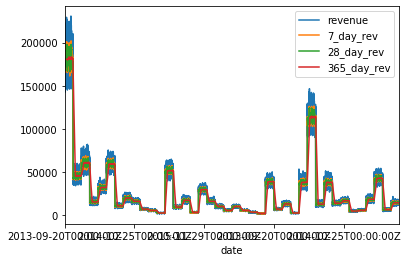

<Figure size 432x288 with 0 Axes>

In [22]:
# Compute 7_day_rev
daily_revenue['7_day_rev'] = daily_revenue.revenue.rolling(window=7,center=False).mean()

# Compute 28_day_rev
daily_revenue['28_day_rev'] = daily_revenue.revenue.rolling(window=28,center=False).mean()
    
# Compute 365_day_rev
daily_revenue['365_day_rev'] = daily_revenue.revenue.rolling(window=365,center=False).mean()
    
# Plot date, and revenue, along with the 3 rolling functions (in order)    

fig = plt.figure(figsize=(20, 10))
daily_revenue.plot(x='date', y=['revenue', '7_day_rev', '28_day_rev', '365_day_rev', ])
plt.show()
plt.tight_layout()

## Exponential rolling average & over/under smoothing
In the previous exercise, we saw that our revenue is somewhat flat over time. In this exercise we will dive deeper into the data to see if we can determine why this is the case. We will look at the revenue for a single in-app purchase product we are selling to see if this potentially reveals any trends. As this will have less data then looking at our overall revenue it will be much noisier. To account for this we will smooth the data using an exponential rolling average.

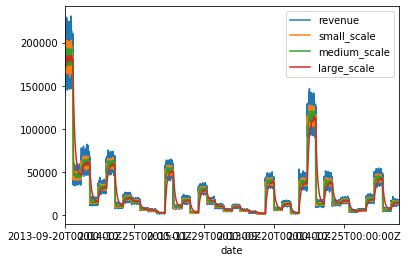

In [23]:
# Calculate 'small_scale'
daily_revenue['small_scale'] = daily_revenue.revenue.ewm(span=10).mean()

# Calculate 'medium_scale'
daily_revenue['medium_scale'] = daily_revenue.revenue.ewm(span=100).mean()

# Calculate 'large_scale'
daily_revenue['large_scale'] = daily_revenue.revenue.ewm(span = 500).mean()

# Plot 'date' on the x-axis and, our three averages and 'revenue'
# on the y-axis
daily_revenue.plot(x = 'date', y =['revenue', 'small_scale', 'medium_scale', 'large_scale'])
plt.show()

## Visualizing user spending
Recently, the Product team made some big changes to both the Android & iOS apps. They do not have any direct concerns about the impact of these changes, but want you to monitor the data to make sure that the changes don't hurt company revenue. Additionally, the product team believes that some of these changes may impact female users more than male users.

In [24]:
user_revenue['month'] = pd.to_datetime(user_revenue['date']).dt.to_period('M')


C:\Users\jason\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


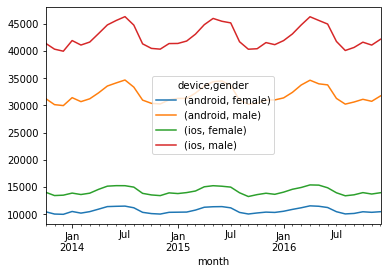

In [25]:
# Pivot user_revenue
pivoted_data = pd.pivot_table(user_revenue, values ='revenue', columns=['device', 'gender'], index='month')
pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]

# Create and show the plot
pivoted_data.plot()
plt.show()

From this view, it seems like our aggregate revenue is fairly stable, so the changes are most likely not hurting revenue.

# AB Test

Experimental units: Revenue per user day
We are going to check what happens when we add a consumable paywall to our app. A paywall is a feature of a website or other technology that requires payment from users in order to access additional content or services.

Here, you'll practice calculating experimental units and baseline values related to our consumable paywall. Both measure revenue only among users who viewed a paywall. Your job is to calculate revenue per user-day, with user-day as the experimental unit.

In [26]:
purchase_data.drop('month1', axis = 1, inplace = True)

In [27]:
# Extract the 'day'; value from the timestamp
purchase_data.date = purchase_data.date.dt.floor('d')

# Replace the NaN price values with 0 
purchase_data.price = np.where(np.isnan(purchase_data.price), 0, purchase_data.price)

# Aggregate the data by 'uid' & 'date'
purchase_data_agg = purchase_data.groupby(by=['uid', 'date'], as_index=False)
revenue_user_day = purchase_data_agg['price'].sum()

# Calculate the final average
revenue_user_day = revenue_user_day['price'].mean()
print(revenue_user_day)

407.95033407572384


In [33]:
demographics_data = pd.read_csv("user_demographics_paywall.csv")

demographics_data.head()

,uid,reg_date,device,gender,country,age
0,52774929,2018-03-07T00:00:00Z,and,F,FRA,27
1,40143397,2016-07-02T00:00:00Z,and,F,DEU,56
2,89856430,2017-06-05T00:00:00Z,and,M,TUR,31
3,76188504,2016-09-24T00:00:00Z,iOS,M,BRA,54
4,76493748,2017-06-07T00:00:00Z,iOS,M,BRA,24


# Exploring the power calculation
As discussed, power is the probability of rejecting the null hypothesis when the alternative hypothesis is true. Here you will explore some properties of the power function and see how it relates to sample size among other parameters. The get_power() function has been included and takes the following arguments in the listed order n for sample size, p1 as the baseline value, p2 as the value with lift included, and cl as the confidence level.

In [34]:
from scipy import stats
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    
    power = power_part_one + power_part_two
    
    return (power)

In [37]:
p1 = 0.1
p2 = 0.12
cl = 0.95
n1 = 1000

In [38]:
# Look at the impact of sample size increase on power
n_param_one = get_power(n=1000, p1=p1, p2=p2, cl=cl)
n_param_two = get_power(n=2000, p1=p1, p2=p2, cl=cl)

# Look at the impact of confidence level increase on power
alpha_param_one = get_power(n=n1, p1=p1, p2=p2, cl=0.8)
alpha_param_two = get_power(n=n1, p1=p1, p2=p2, cl=0.95)
    
# Compare the ratios
print(n_param_two / n_param_one)
print(alpha_param_one / alpha_param_two)

1.7596440001351992
1.8857367092232278


With these particular values it looks like decreasing our confidence level has a slightly larger impact on the power than increasing our sample size

In [40]:
purchase_data.shape

(9006, 9)